In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

df = pd.read_csv("heart.csv")
display(df.head())
display(df.info())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


None

In [3]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

display(X.describe())

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


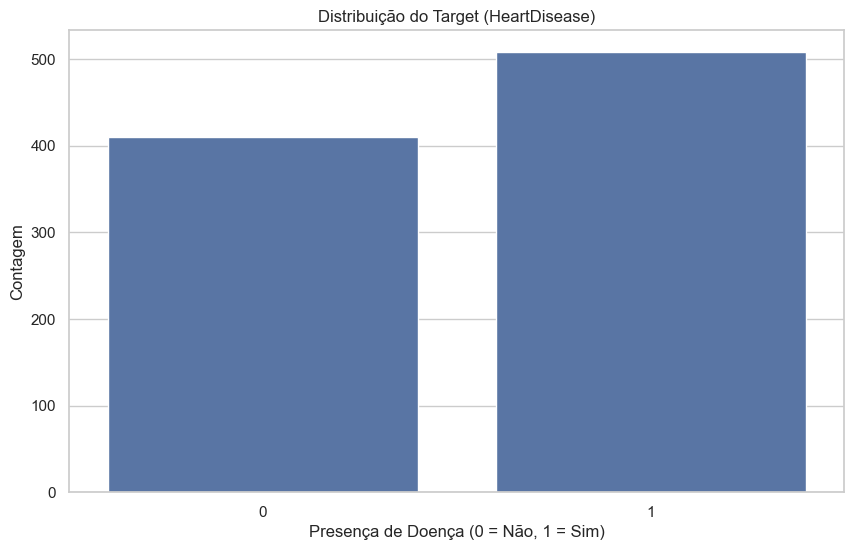

In [4]:
# Distribuição do target
sns.countplot(x=y)
plt.title("Distribuição do Target (HeartDisease)")
plt.xlabel("Presença de Doença (0 = Não, 1 = Sim)")
plt.ylabel("Contagem")
plt.show()

In [5]:
# Correlação numérica com o target
df_corr = df.copy()
df_corr["HeartDisease"] = y
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

correlations = df_corr[num_cols + ["HeartDisease"]].corr()["HeartDisease"].sort_values(ascending=False)
print("Correlação com a variável alvo:")
print(correlations)

Correlação com a variável alvo:
HeartDisease    1.000000
Oldpeak         0.403951
Age             0.282039
FastingBS       0.267291
RestingBP       0.107589
Cholesterol    -0.232741
MaxHR          -0.400421
Name: HeartDisease, dtype: float64


In [6]:
# Identificação de colunas numéricas e categóricas
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Transformador com padronização e one-hot encoding
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"Acurácia com K=5: {acc:.4f}")

Acurácia com K=5: 0.8859


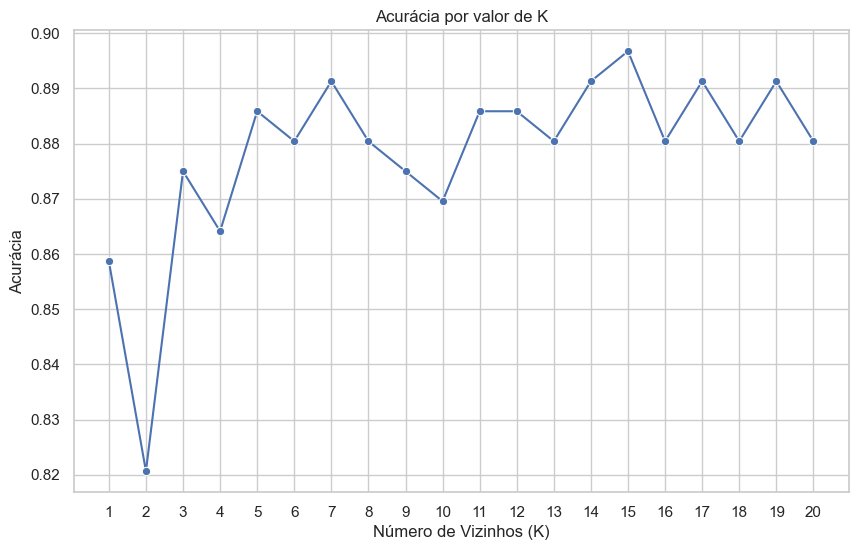

Melhor K encontrado: 15 com acurácia = 0.8967


In [8]:
# Testa a acurácia para K, variando de 1 a 20
k_values = list(range(1, 21))
accuracies = []

for k in k_values:
    pipeline.set_params(knn__n_neighbors=k)
    pipeline.fit(X_train, y_train)
    y_pred_k = pipeline.predict(X_val)
    acc_k = accuracy_score(y_val, y_pred_k)
    accuracies.append(acc_k)

sns.lineplot(x=k_values, y=accuracies, marker="o")
plt.title("Acurácia por valor de K")
plt.xlabel("Número de Vizinhos (K)")
plt.ylabel("Acurácia")
plt.xticks(k_values)
plt.grid(True)
plt.show()

melhor_k = k_values[np.argmax(accuracies)]
print(f"Melhor K encontrado: {melhor_k} com acurácia = {max(accuracies):.4f}")

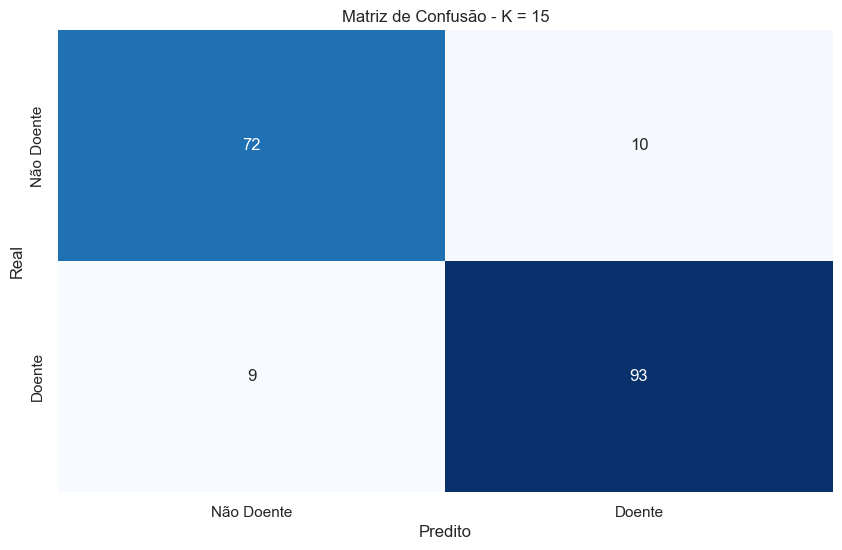

In [9]:
pipeline.set_params(knn__n_neighbors=melhor_k)
pipeline.fit(X_train, y_train)
y_pred_final = pipeline.predict(X_val)

# Gera a matriz de confusão
cm = confusion_matrix(y_val, y_pred_final)

# Visualização com seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Não Doente", "Doente"],
            yticklabels=["Não Doente", "Doente"])

plt.title(f"Matriz de Confusão - K = {melhor_k}")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


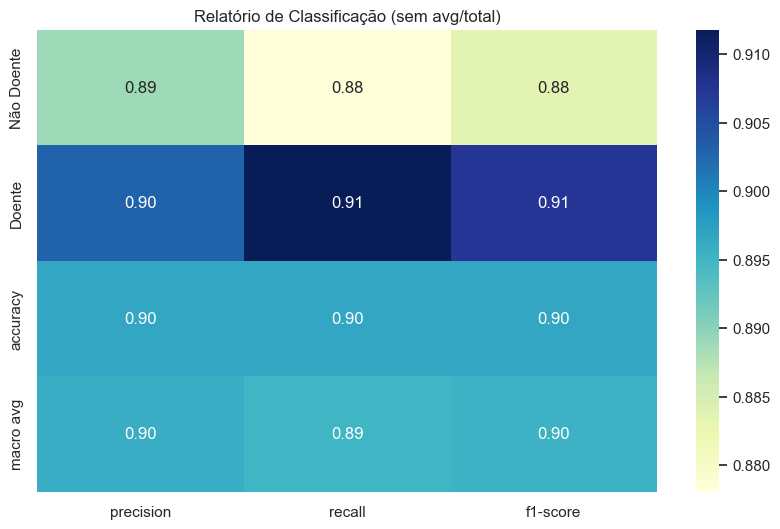

In [10]:
report_dict = classification_report(
    y_val, y_pred_final, target_names=["Não Doente", "Doente"], output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose()

sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Relatório de Classificação (sem avg/total)")
plt.show()